## **Anomaly detection for vibration bearings**

In [50]:
#import package

import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as md

from numpy.random import seed

from keras.layers import Input, Dropout
from keras.layers.core import Dense
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

In [51]:
#Import dataset

data = pd.read_csv("BearingVibration_Dataset.csv")
data

,Unnamed: 0,Bearing 1,Bearing 2,Bearing 3,Bearing 4
0,2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
1,2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2,2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
3,2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
4,2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659
...,...,...,...,...,...
977,2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
978,2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
979,2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817
980,2004-02-19 06:12:39,0.001857,0.003732,0.003656,0.001786


In [52]:
#Rename the first column

data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
data

,Date,Bearing 1,Bearing 2,Bearing 3,Bearing 4
0,2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
1,2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2,2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
3,2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
4,2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659
...,...,...,...,...,...
977,2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
978,2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
979,2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817
980,2004-02-19 06:12:39,0.001857,0.003732,0.003656,0.001786


In [53]:
#Get the data info

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       982 non-null    object 
 1   Bearing 1  982 non-null    float64
 2   Bearing 2  982 non-null    float64
 3   Bearing 3  982 non-null    float64
 4   Bearing 4  982 non-null    float64
dtypes: float64(4), object(1)
memory usage: 38.5+ KB
None


In [54]:
#Set Date column as index

data = data.set_index('Date')
data

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
Date,,,,
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659
...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817


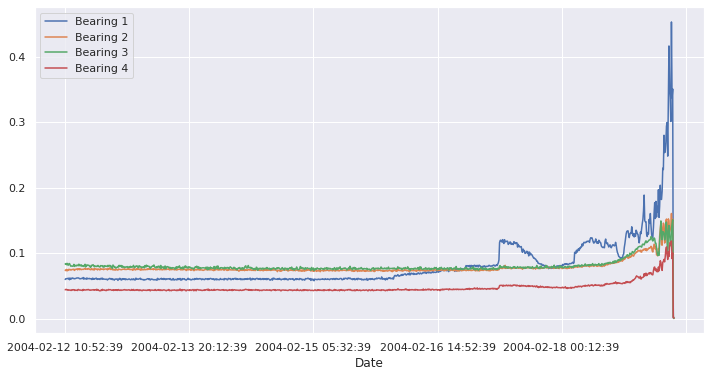

In [55]:
#Plot all the data

data.plot(figsize = (12,6))

From the plot above, we know that the vibration will be bigger when the last of the month. For the quick assumption, the anomaly of bearings' vibration may be happen mostly in last month.

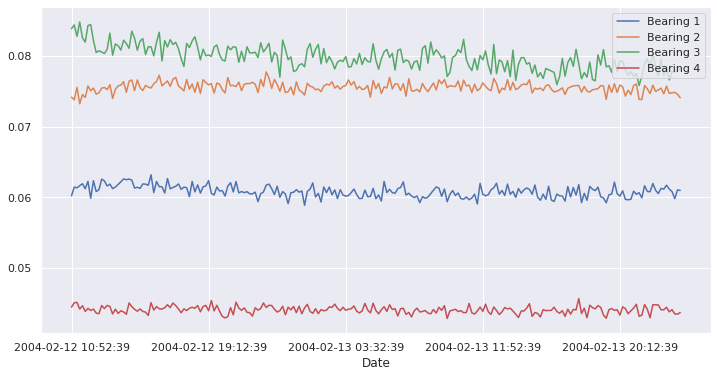

In [56]:
#Set training and testing data
#Selection of training data on that date based on a plot above that shows normal data

data_train = data['2004-02-12 10:52:39':'2004-02-13 23:52:39']
data_test = data['2004-02-13 23:52:39':]
data_train.plot(figsize = (12,6))

In [57]:
#Define the function
#Normalize data

scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(data_train), 
                              columns=data_train.columns, 
                              index=data_train.index)

X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(data_test), 
                             columns=data_test.columns, 
                             index=data_test.index)

In [58]:
#PCA to reduce the data dimension

from sklearn.decomposition import PCA
PCA = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = PCA.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = PCA.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [59]:
#Calculate the covariance matrix

def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [60]:
#Calculate Mahalanobis distance

def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [61]:
#Detecting outliers

def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [62]:
#Calculate threshold

def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [63]:
#Check if matrix is positive definite

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [64]:
#Define PCA for training adn testing dataset

data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [65]:
#calculate covariance matrix

cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [66]:
#Calculate means for data training

mean = data_train.mean(axis=0)
mean

array([-4.77943544e-17,  2.78800401e-17])

In [67]:
#Calculate distance for training and testing dataset and calculate threshold to detect anomaly

distance_test = MahalanobisDist(inv_cov_matrix, mean, data_test, verbose=False)
distance_train = MahalanobisDist(inv_cov_matrix, mean, data_train, verbose=False)
threshold = MD_threshold(distance_train, extreme = True)

In [68]:
threshold

3.81801118129221

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Mahalanobis distance')

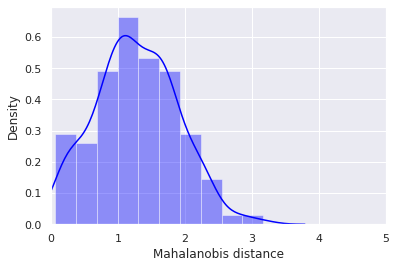

In [69]:
plt.figure()
sns.distplot(distance_train,
             bins = 10, 
             kde= True, 
            color = 'blue');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis distance')

It is proven that the day with Mahalanobis distance above 3 is outlier or anomaly.

In [70]:
anomaly_train = pd.DataFrame()
anomaly_train['Mhb dist']= distance_train
anomaly_train['Thresh'] = threshold
# If Mahalanobis distance above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mhb dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mhb dist']= distance_test
anomaly['Thresh'] = threshold
# If Mahalanobisb distance above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mhb dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mhb dist,Thresh,Anomaly
Date,,,
2004-02-13 23:52:39,1.035972,3.818011,False
2004-02-14 00:02:39,1.133269,3.818011,False
2004-02-14 00:12:39,1.514723,3.818011,False
2004-02-14 00:22:39,1.812835,3.818011,False
2004-02-14 00:32:39,0.787156,3.818011,False


In [71]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

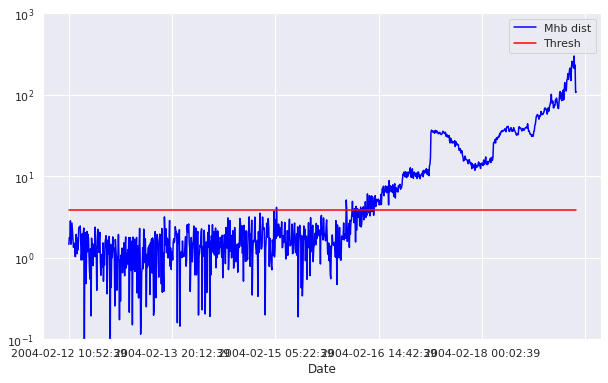

In [72]:
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['blue','red'])

From the plot above proven that our quick assumption is true. The anomaly is occur almost in the last month, spesifically at 16th December 2004 afternoon.